# Hazard assessment for river flooding using river discharge statistics

This workflow uses the dataset of hydrological climate impact indicators by SMHI that is [available via the Copernicus Data Store](https://doi.org/10.24381/cds.73237ad6).

The following variables are used in this workflow:
- gridded historical river discharges  (daily timeseries) based on the E-HYPEgrid model.
- flood recurrence (2, 5, 10, 50 year return periods) for historical and future climate scenarios based on the E-HYPEcatch model.

The resolution of the gridded dataset is 5km.

Historical data is available for 1971-2005. 

Flood recurrence data is available for different return periods computed for various timelines:
- early century (2011-2040)
- mid-century (2041-2070)
- end-century (2071-2100)

For each time period, climate scenarios RCP2.6, RCP4.5 and RCP8.5 are available. 

Relative increases in flood recurrence for these periods are expressed relative to the reference period (1971-2000).

(more information on the dataset and limitations to be added)


## Preparation work

### Select area of interest
First, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the dataset for further processing focusing on the specific area.

In [1]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box

# Examples:
#areaname = 'Putna_Romania'
#bbox = [25.34068,47.740031,25.884503,47.964885] 
#loc = [25.61, 47.865]

#areaname = 'Zilina_Slovakia'
#bbox = [18.463238,49.127604,19.007062,49.346389] 
#loc = [18.717, 49.25]

areaname = 'Maastricht_NL'
bbox = [5.4268,50.7288,6.0,51.089]
loc = [5.697, 50.849]

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- cdsapi
- zipfile
- cartopy
- geopandas

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [2]:
import os
from glob import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi
import zipfile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
In the next cell will create the directory called 'FLOOD_RIVER_discharges' in the same directory where this notebook is saved.

In [3]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_discharges'
os.makedirs(workflow_folder, exist_ok=True)

data_folder = os.path.join(workflow_folder, 'data')
os.makedirs(data_folder, exist_ok=True)

data_folder_gridded = os.path.join(data_folder, 'EHYPEgrid')
os.makedirs(data_folder_gridded, exist_ok=True)

data_folder_catch = os.path.join(data_folder, 'EHYPEcatch')
os.makedirs(data_folder_catch, exist_ok=True)

In [4]:
# Define directory for plots within the previously defined workflow folder
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Exploring historical river discharges 

### Daily river discharge timeseries based on the gridded hydrological dataset

We will download the river discharges data for a historical period. This data is generated using the E-HYPEgrid model.

In [5]:
client = cdsapi.Client()

2025-06-24 17:06:41,517 WARNING [2025-06-23T00:00:00] Scheduled System Session affecting Service reliability - 30 June 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-30-june-2025/13598)
2025-06-24 17:06:41,518 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-24 17:06:41,519 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-24 17:06:41,520 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [6]:
years = list(range(2000, 2005))
gcms = ["hadgem2_es","mpi_esm_lr","mpi_esm_lr"]
rcms = ["racmo22e","rca4","csc_remo2009"]

In [26]:
for ii, rcm in enumerate(rcms):
    gcm = gcms[ii]

    file = os.path.join(data_folder_gridded, 'download.zip')
    dataset = "sis-hydrology-variables-derived-projections"
    request = {
        "product_type": "essential_climate_variables",
        "variable": ["river_discharge"],
        "variable_type": "absolute_values",
        "time_aggregation": "daily",
        "experiment": ["historical"],
        "hydrological_model": ["e_hypegrid"],
        "rcm": rcm, 
        "gcm": gcm,
        "ensemble_member": ["r1i1p1"],
        "period":  [str(x) for x in years], 
    }
    client.retrieve(dataset, request, file)

    # Unzip the file that was just downloaded, and remove the zip file
    with zipfile.ZipFile(file, 'r') as zObject:
        zObject.extractall(path=data_folder_gridded)
    os.remove(file)

2025-06-24 11:46:57,413 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-06-24 11:46:57,414 INFO Request ID is c07073d1-2f97-4864-8ea5-4925b498076f
2025-06-24 11:46:57,644 INFO status has been updated to accepted
2025-06-24 11:47:06,321 INFO status has been updated to running
2025-06-24 12:35:41,062 INFO status has been updated to successful


'FLOOD_RIVER_discharges\\data\\EHYPEgrid\\download.zip'

Defining functions we will use to simplify loading the data and plotting.

In [15]:
def load_datasets(filenames):
    ds = xr.open_mfdataset(filenames)
    ds.lon.load()
    ds.lat.load()
    ds = ds.set_coords(['lon','lat'])
    if 'time' in list(ds.lat.coords):
        ds['lat'] = ds['lat'].isel(time=0)
    if 'time' in list(ds.lon.coords):
        ds['lon'] = ds['lon'].isel(time=0)        
    return ds

def subset_dataset_bbox(ds, bbox):  # Subset dataset to area selection with bounding box
    ds_sel = ds.where((ds.lon > bbox[0]-0.1) & (ds.lon < bbox[2]+0.1) & (ds.lat > bbox[1]-0.1) & (ds.lat < bbox[3]+0.1), drop=True)
    return ds_sel

def find_index_location(ds, loc): # Find indices of the cell closest to location coordinates
    abslat = np.abs(ds.lat-loc[1])
    abslon = np.abs(ds.lon-loc[0])
    c = np.maximum(abslon, abslat)
    ([yloc], [xloc]) = np.where(c == np.min(c))
    return xloc, yloc

# def add_cartopy_features(ax):
#     ax.add_feature(cfeature.LAND, edgecolor='black')
#     ax.add_feature(cfeature.OCEAN, edgecolor='black')
#     ax.add_feature(cfeature.RIVERS, edgecolor='orange')
#     ax.add_feature(cfeature.BORDERS, edgecolor='black')
#     states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
#     ax.add_feature(states_provinces, edgecolor='gray')
#     return

In [27]:
# Load dataset
files = glob(os.path.join(data_folder_gridded,'rdis_day_E-HYPEgrid-EUR-11_MOHC-HadGEM2-ES_historical_r1i1p1_KNMI-RACMO22E_*_grid5km_v1.nc'))
ds_dis_1 = load_datasets(files); del files

files = glob(os.path.join(data_folder_gridded, 'rdis_day_E-HYPEgrid-EUR-11_MPI-M-MPI-ESM-LR_historical_r1i1p1_SMHI-RCA4_*_grid5km_v1.nc'))
ds_dis_2 = load_datasets(files); del files

In [28]:
ds_dis_1

<xarray.Dataset> Size: 7GB
Dimensions:  (y: 950, x: 1000, time: 1827)
Coordinates:
    lat      (y, x) float32 4MB 27.8 27.81 27.82 27.83 ... 58.32 58.28 58.25
  * time     (time) datetime64[ns] 15kB 2000-01-01 2000-01-02 ... 2004-12-31
    lon      (y, x) float32 4MB -8.229 -8.18 -8.131 -8.082 ... 73.83 73.88 73.94
Dimensions without coordinates: y, x
Data variables:
    rdis     (time, y, x) float32 7GB dask.array<chunksize=(1, 950, 1000), meta=np.ndarray>
Attributes: (12/26)
    CDI:                      Climate Data Interface version 1.9.8 (https://m...
    NCO:                      "4.6.3"
    CDO:                      Climate Data Operators version 1.9.8 (https://m...
    Conventions:              CF-1.6
    variable_name:            rdis
    invar_gcm_model_id:       MOHC-HadGEM2-ES
    ...                       ...
    history:                  E-HYPEgrid output
    title:                    River discharge
    summary:                  Calculated as  daily simulated outflow from a s...
    keywords:                 river flow, flux
    time_period:              2000
    contact:                  copernicus-support@ecmwf.int

In [29]:
ds_dis_1_sel = subset_dataset_bbox(ds_dis_1, bbox)
ds_dis_2_sel = subset_dataset_bbox(ds_dis_2, bbox)

In [ ]:
# Find indices of the grid cell closest to the location of interest
xloc, yloc = find_index_location(ds_dis_1, loc)

The plot below illustrates the resolution of the gridded dataset and allows us to check the river discharge timeseries based on two different GCM-RCM combinations. The range and seasonal/monthly pattern of these timeseries allows us to understand better the applicability of the dataset to the specific region, by comparing it to known historical river discharges. 

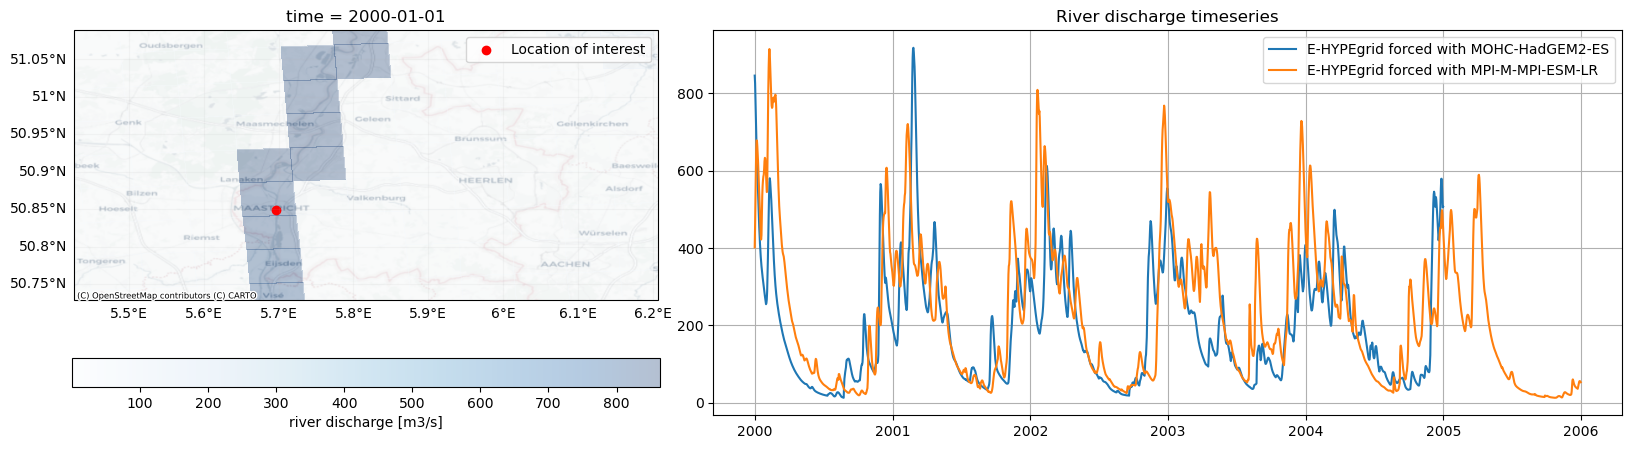

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax0 = plt.subplot2grid((1, 5), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=3)

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

ds_dis_1_sel.rdis.isel(time=0).plot(ax=ax0, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.3, cmap='Blues', cbar_kwargs={'location':'bottom'})

ctx.add_basemap(ax=ax0,crs='EPSG:4326',source=ctx.providers.CartoDB.Positron, attribution_size=6)

ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

# Plot discharge timeseries
ax1.plot(ds_dis_1.time, ds_dis_1.sel(x=xloc, y=yloc).rdis, label=f'E-HYPEgrid forced with {ds_dis_1.attrs['invar_gcm_model_id']}')
ax1.plot(ds_dis_2.time, ds_dis_2.sel(x=xloc, y=yloc).rdis, label=f'E-HYPEgrid forced with {ds_dis_2.attrs['invar_gcm_model_id']}')
ax1.grid()
ax1.legend()
ax1.title.set_text('River discharge timeseries')

fig.tight_layout()

### Historical river discharge statistics based on gridded data

Downloading monthly means of river discharges from gridded dataset for the historical period (1971-2000).

In [40]:
for ii, rcm in enumerate(rcms):
    gcm = gcms[ii]

    file = os.path.join(data_folder_gridded, 'download.zip')
    dataset = "sis-hydrology-variables-derived-projections"
    request = {
        "product_type": "climate_impact_indicators",
        "variable": ["river_discharge"],
        "variable_type": "absolute_values",
        "time_aggregation": "monthly_mean",
        "experiment": ["historical"],
        "hydrological_model": ["e_hypegrid"],
        "rcm": rcm,
        "gcm": gcm,
        "ensemble_member": ["r1i1p1"],
        "period": ["1971_2000"]
    }
    client.retrieve(dataset, request, file)

    # Unzip the file that was just downloaded, and remove the zip file
    with zipfile.ZipFile(file, 'r') as zObject:
        zObject.extractall(path=data_folder_gridded)
    os.remove(file)

2025-06-24 14:09:01,692 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-06-24 14:09:01,693 INFO Request ID is abf5ce65-bb37-440b-b226-149ee99f3899
2025-06-24 14:09:01,776 INFO status has been updated to accepted
2025-06-24 14:09:15,294 INFO status has been updated to running
2025-06-24 14:13:25,586 INFO status has been updated to successful
2025-06-24 14:13:55,229 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-06-24 14:13:55,230 INFO Request ID is ad816d80-cbdf-4f58-ab88-e2280bf9e062
2025-06-24 14:13:55,559 INFO status has been updated to accepted
2025-06-24 14:14:

In order to load all mean discharge datasets in one variable we will use a preprocess function to add GCM and RCM names as a variable. These model names are derived directly from the filename.

In [113]:
def preprocess_add_gcm(ds):
    ds = ds.set_coords(['lon','lat'])
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['models'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('models').expand_dims('models')
    return ds

Opening monthly river discharge statistics from 3 different gcm-rcm combinations:

In [ ]:
files = glob(os.path.join(data_folder_gridded, 'rdis_ymonmean_abs_E-HYPEgrid-EUR-11_*_historical_r1i1p1_*_na_1971-2000_grid5km_v1.nc'))
ds_dis = xr.open_mfdataset(files, preprocess=preprocess_add_gcm)
ds_dis.load()

<xarray.Dataset> Size: 144MB
Dimensions:        (models: 3, time: 12, y: 950, x: 1000)
Coordinates:
    lat            (y, x) float32 4MB 27.8 27.81 27.82 ... 58.32 58.28 58.25
    lon            (y, x) float32 4MB -8.229 -8.18 -8.131 ... 73.83 73.88 73.94
  * time           (time) datetime64[ns] 96B 2000-01-01 ... 2000-12-01
  * models         (models) <U36 432B 'MOHC-HadGEM2-ES_KNMI-RACMO22E-v2' ... ...
Dimensions without coordinates: y, x
Data variables:
    rdis_ymonmean  (models, time, y, x) float32 137MB nan nan nan ... nan nan
Attributes: (12/27)
    CDI:                      Climate Data Interface version 1.9.8 (https://m...
    NCO:                      "4.6.3"
    CDO:                      Climate Data Operators version 1.9.8 (https://m...
    source:                   A set of EURO-CORDEX EUR-11 RCM was bias adjust...
    institution:              SMHI, www.smhi.se
    Conventions:              CF-1.6
    ...                       ...
    title:                    Mean monthly river discharge
    summary:                  Calculated as the monthly mean values of daily ...
    keywords:                 river flow, flux
    variable_name:            rdis_ymonmean
    history:                  CDO commands (last cdo command first and separa...
    contact:                  copernicus-support@ecmwf.int

In [ ]:
# Subset the dataset to the area of interest and find location indices
ds_dis_sel = subset_dataset_bbox(ds_dis, bbox)
xloc, yloc = find_index_location(ds_dis, loc)

The plot below shows the monthly means of river discharge in the historical period (1971-2000) across the three GCM-RCM combinations.

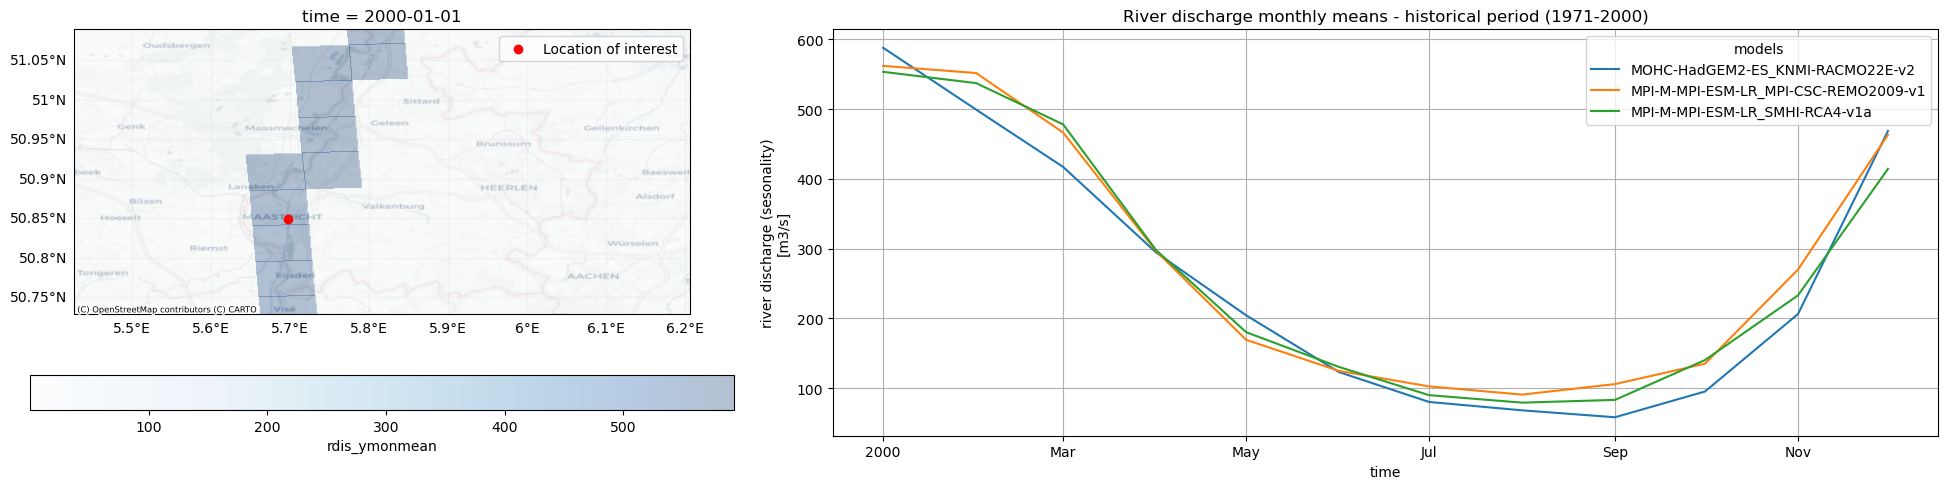

In [128]:
fig = plt.figure(figsize=(20, 5))
ax0 = plt.subplot2grid((1, 5), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=3)

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

ds_dis_sel.rdis_ymonmean.isel(time=0).mean(dim='models').plot(ax=ax0, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.3, cmap='Blues', cbar_kwargs={'location':'bottom'})
ctx.add_basemap(ax=ax0,crs='EPSG:4326',source=ctx.providers.CartoDB.Positron, attribution_size=6)
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

# Plot discharge monthly means
ds_dis.sel(x=xloc, y=yloc)['rdis_ymonmean'].plot.line(hue='models')
ax1.grid()
ax1.title.set_text('River discharge monthly means - historical period (1971-2000)')

fig.tight_layout()

### Historical river discharge statistics based on catchment data

Catchment-level data is stored in a NetCDF file where a specific catchment can be selected by catchment ID. In order to know the ID of the catchment we are interested in, we need to consult the map of catchments (sub-basins) [available in shp format on Zenodo](https://doi.org/10.5281/zenodo.581451). Please download the dataset of subbasins from Zenodo and unzip it in the folder specied below as `data_folder_subbasins`.

Reference to the dataset of subbasin contours:  
Isberg, K. (2017). EHYPE3_subbasins.zip [Data set]. Zenodo. https://doi.org/10.5281/zenodo.581451

In [15]:
data_folder_subbasins = os.path.join(data_folder, 'EHYPE3_subbasins')

In [16]:
# Open dataset with subbasin contours
try:
    catchments = gpd.GeoDataFrame.from_file(os.path.join(data_folder_subbasins, 'EHYPE3_subbasins.shp'))
    print("Dataset loaded.")
except:
    print(f"Dataset with subbasin contours not found. Please download it and place it in the folder {data_folder_subbasins}")

Dataset loaded.


The dataset of subbasin contours was loaded as a GeoDataFrame, we can check its contents:

In [17]:
catchments

,SUBID,HAROID,geometry
0,8801544.0,8801544.0,"MULTIPOLYGON (((-22.9068 65.75671, -22.92437 6..."
1,8801548.0,8801548.0,"POLYGON ((-24.42223 65.55144, -24.39406 65.537..."
2,8000005.0,8000006.0,"MULTIPOLYGON (((9.3944 59.15315, 9.41203 59.14..."
3,8115258.0,8000006.0,"POLYGON ((8.5962 59.30061, 8.59918 59.29174, 8..."
4,8115717.0,8000006.0,"POLYGON ((9.27409 59.01988, 9.27962 59.00213, ..."
...,...,...,...
35403,9566395.0,9566395.0,"POLYGON ((0.15417 49.37083, 0.15417 49.3625, 0..."
35404,9581818.0,9581818.0,"MULTIPOLYGON (((-4.89583 55.7375, -4.87917 55...."
35405,9524166.0,9524166.0,"MULTIPOLYGON (((-1.12917 45.34583, -1.12083 45..."
35406,9581815.0,9581815.0,"MULTIPOLYGON (((-4.89583 56.15417, -4.89583 56..."


Now we need to identify the id of the catchment where the point of interest is located:

In [18]:
point = Point((loc[0],loc[1]))

in_catchment = catchments.geometry.contains(point)

catch_id = int(catchments.iloc[in_catchment.index[in_catchment==True]].SUBID.values.tolist()[0])
print(f'Catchment ID in the E-HYPEcatch dataset: {catch_id}')

Catchment ID in the E-HYPEcatch dataset: 9503381


In [19]:
catchment = catchments[catchments.SUBID==catch_id]
catchment

,SUBID,HAROID,geometry
26859,9503381.0,9507523.0,"POLYGON ((5.67917 50.92083, 5.67917 50.9125, 5..."


Text(0.5, 1.0, 'Catchment contours from E-HYPEcatch corresponding to the location of interest')

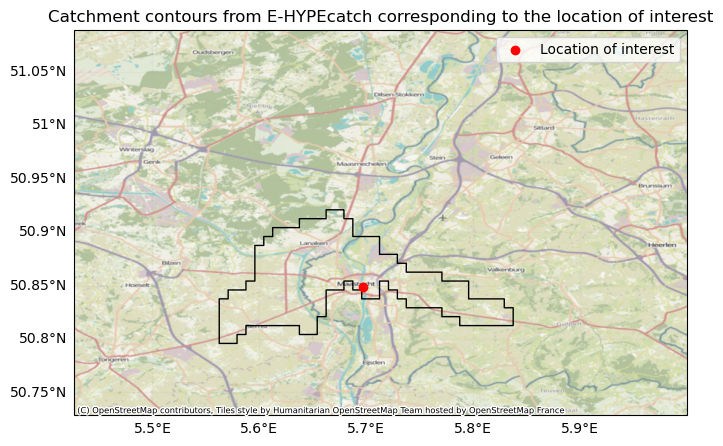

In [148]:
# Plot the catchment on a ctx map
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot2grid((1, 1), (0, 0), colspan=2, projection=ccrs.PlateCarree())

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

catchment.geometry.plot(ax=ax0, facecolor='None')

ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)

ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')



Downloading catchment-level discharge data for historical period. Data is available based on different E-HYPEcatch model reaalizations. We will download all model realizations.

In [ ]:
for ii, rcm in enumerate(rcms):
    gcm = gcms[ii]

    for id in range(8):
        catchmodel = f'e_hypecatch_m{id:02}'

        file = os.path.join(data_folder_catch, 'download.zip')
        dataset = "sis-hydrology-variables-derived-projections"
        request = {
            "product_type": "climate_impact_indicators",
            "variable": ["river_discharge"],
            "variable_type": "absolute_values",
            "time_aggregation": "monthly_mean",
            "experiment": ["historical"],
            "hydrological_model": [catchmodel],
            "rcm": rcm,
            "gcm": gcm,
            "ensemble_member": ["r1i1p1"],
            "period": ["1971_2000"]
        }
        client.retrieve(dataset, request, file)

        # Unzip the file that was just downloaded, and remove the zip file
        with zipfile.ZipFile(file, 'r') as zObject:
            zObject.extractall(path=data_folder_catch)
        os.remove(file)


2025-06-24 17:18:58,866 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-06-24 17:18:58,867 INFO Request ID is f2ada899-aa91-4b5a-8a0f-106cc2c47d97
2025-06-24 17:18:58,934 INFO status has been updated to accepted
2025-06-24 17:19:07,660 INFO status has been updated to successful
2025-06-24 17:19:08,620 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-06-24 17:19:08,621 INFO Request ID is d4285453-ec41-402c-ae95-2216c3103322
2025-06-24 17:19:08,840 INFO status has been updated to accepted
2025-06-24 17:19:17,176 INFO status has been updated to running
2025-06-24 17:23:

Preprocess function to inclide model names and model configuraton in the dataset dimensions:

In [20]:
def preprocess_add_gcm_catch(ds):
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['gcm_rcm'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('gcm_rcm').expand_dims('gcm_rcm')

    ds['catchmodel'] = filename.split("_")[3]
    ds = ds.set_coords('catchmodel').expand_dims('catchmodel')    
    return ds

Open catchment-level river discharge data for the historical period:

In [21]:
files = glob(os.path.join(data_folder_catch, 'rdis_tmean_abs_E-HYPEcatch*-EUR-11_*_historical_r1i1p1_*_na_1971-2000_catch_v1.nc'))
ds_cat = xr.open_mfdataset(files, preprocess=preprocess_add_gcm_catch)

In [24]:
ds_cat

<xarray.Dataset> Size: 3MB
Dimensions:     (catchmodel: 8, gcm_rcm: 3, time: 1, id: 34810)
Coordinates:
  * time        (time) datetime64[ns] 8B 1971-01-01
  * id          (id) int32 139kB 8801654 8000123 8212459 ... 9605711 9601936
  * gcm_rcm     (gcm_rcm) <U36 432B 'MOHC-HadGEM2-ES_SMHI-RCA4-v1' ... 'MPI-M...
  * catchmodel  (catchmodel) <U20 640B 'E-HYPEcatch00-EUR-11' ... 'E-HYPEcatc...
Data variables:
    rdis_tmean  (catchmodel, gcm_rcm, time, id) float32 3MB dask.array<chunksize=(1, 1, 1, 34810), meta=np.ndarray>
Attributes: (12/28)
    CDI:                      Climate Data Interface version 1.9.5 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    comment:                  -
    CDO:                      Climate Data Operators version 1.9.5 (http://mp...
    history:                  CDO commands (last cdo command first and separa...
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      19710101
    time_coverage_end:        20001231
    variable_name:            rdis_tmean
    contact:                  copernicus-support@ecmwf.int

In [ ]:
#ds_cat.sel(id=catch_id).rdis_tmean.plot.line(hue='gcm_rcm')

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

In [ ]:
# Visualize catchment historical discharges

## Flood occurence in historical and future climates

Based on catchment-level dataset (E-HYPEcatch).

Download flood occurence for different RPs, climate scenarios, timelines, catchment models

Downloading 50 yr return period flood recurrence for the historical climate:

In [ ]:
for ii, rcm in enumerate(rcms):
    gcm = gcms[ii]

    request = {
        "product_type": "climate_impact_indicators",
        "variable": ["flood_recurrence_50_years_return_period"],
        "variable_type": "absolute_values",
        "time_aggregation": "annual_mean",
        "experiment": ["historical"],
        "hydrological_model": [
            "e_hypecatch_m00",
            "e_hypecatch_m01",
            "e_hypecatch_m02",
            "e_hypecatch_m03",
            "e_hypecatch_m04",
            "e_hypecatch_m05",
            "e_hypecatch_m06",
            "e_hypecatch_m07"
        ],
        "rcm": rcm,
        "gcm": gcm,
        "ensemble_member": ["r1i1p1"],
        "period": ["1971_2000"]
    }
    client.retrieve(dataset, request, file)

    # Unzip the file that was just downloaded, and remove the zip file
    with zipfile.ZipFile(file, 'r') as zObject:
        zObject.extractall(path=data_folder_catch)
    os.remove(file)

Downloading 50 yr return period flood recurrence for the climate scenarios:

In [ ]:
for ii, rcm in enumerate(rcms):
    gcm = gcms[ii]

    request = {
        "product_type": "climate_impact_indicators",
        "variable": ["flood_recurrence_50_years_return_period"],
        "variable_type": "relative_change_from_reference_period",
        "time_aggregation": "annual_mean",
        "experiment": [
            "rcp_4_5",
            "rcp_8_5"
        ],
        "hydrological_model": [
            "e_hypecatch_m00",
            "e_hypecatch_m01",
            "e_hypecatch_m02",
            "e_hypecatch_m03",
            "e_hypecatch_m04",
            "e_hypecatch_m05",
            "e_hypecatch_m06",
            "e_hypecatch_m07"
        ],
        "rcm": "racmo22e",
        "gcm": "hadgem2_es",
        "ensemble_member": ["r1i1p1"],
        "period": [
            "2011_2040",
            "2041_2070",
            "2071_2100"
        ]
    }
    client.retrieve(dataset, request, file)

    # Unzip the file that was just downloaded, and remove the zip file
    with zipfile.ZipFile(file, 'r') as zObject:
        zObject.extractall(path=data_folder_catch)
    os.remove(file)

We will make use of a preprocessing function to write model names and scenarios to the dataset dimensions:

In [ ]:
def preprocess_add_gcm(ds):
    ds = ds.set_coords(['lon','lat'])
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['models'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('models').expand_dims('models')
    return ds

In [ ]:
ds_cat_fut_1 = xr.open_dataset(os.path.join(datadir, 'EHYPEcatch', 'rdisreturnmax50_tmean_rel_E-HYPEcatch07-EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4-v1_2041-2070_1971-2000_catch_v1.nc'))

In [ ]:
# Subset to catchment of interest

In [ ]:
# Visualize flood occurence data - influence of timeline for RCP4.5

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax0 = plt.subplot2grid((1, 2), (0, 0), projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 2), (0, 1), projection=ccrs.PlateCarree(), sharex=ax0, sharey=ax0)

#    plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])

gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
gl = ax1.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
add_cartopy_features(ax0)
add_cartopy_features(ax1)

ds_hist_sel['rdisreturnmax50_tmean'].plot(ax=ax0, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.7, cmap='Blues')
ax0.set_title('1971-2000')
ax0.scatter(loc[0], loc[1], color='red')

ds_fut_1_sel.where(ds_hist_sel['rdisreturnmax50_tmean'].values>20)['rdisreturnmax50_tmean'].plot(ax=ax1, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.7, cmap='RdBu', vmin=-100, vmax=100)
ax1.set_title('2041-2070')
ax1.scatter(loc[0], loc[1], color='red')

plt.suptitle(f'GCM {ds_fut_1.attrs["invar_gcm_model_id"]}, scenario {ds_fut_1.attrs["invar_experiment_name"]}');

In [ ]:
# Visualize flood occurence data - influence of climate scenario